Using device: cuda


100%|██████████| 170M/170M [00:01<00:00, 87.1MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Training VGG-16...
[Epoch 1, Batch 100] Loss: 2.047, Accuracy: 23.69%
[Epoch 1, Batch 200] Loss: 1.647, Accuracy: 38.89%
[Epoch 1, Batch 300] Loss: 1.516, Accuracy: 43.27%
[Epoch 1, Batch 400] Loss: 1.424, Accuracy: 46.92%
[Epoch 1, Batch 500] Loss: 1.321, Accuracy: 51.55%
[Epoch 1, Batch 600] Loss: 1.288, Accuracy: 52.97%
[Epoch 1, Batch 700] Loss: 1.206, Accuracy: 55.95%
[Epoch 2, Batch 100] Loss: 1.216, Accuracy: 57.00%
[Epoch 2, Batch 200] Loss: 1.119, Accuracy: 59.84%
[Epoch 2, Batch 300] Loss: 1.063, Accuracy: 62.31%
[Epoch 2, Batch 400] Loss: 0.977, Accuracy: 65.84%
[Epoch 2, Batch 500] Loss: 0.968, Accuracy: 65.66%
[Epoch 2, Batch 600] Loss: 0.909, Accuracy: 67.69%
[Epoch 2, Batch 700] Loss: 0.893, Accuracy: 68.36%
[Epoch 3, Batch 100] Loss: 0.794, Accuracy: 72.31%
[Epoch 3, Batch 200] Loss: 0.771, Accuracy: 72.72%
[Epoch 3, Batch 300] Loss: 0.735, Accuracy: 74.25%
[Epoch 3, Batch 400] Loss

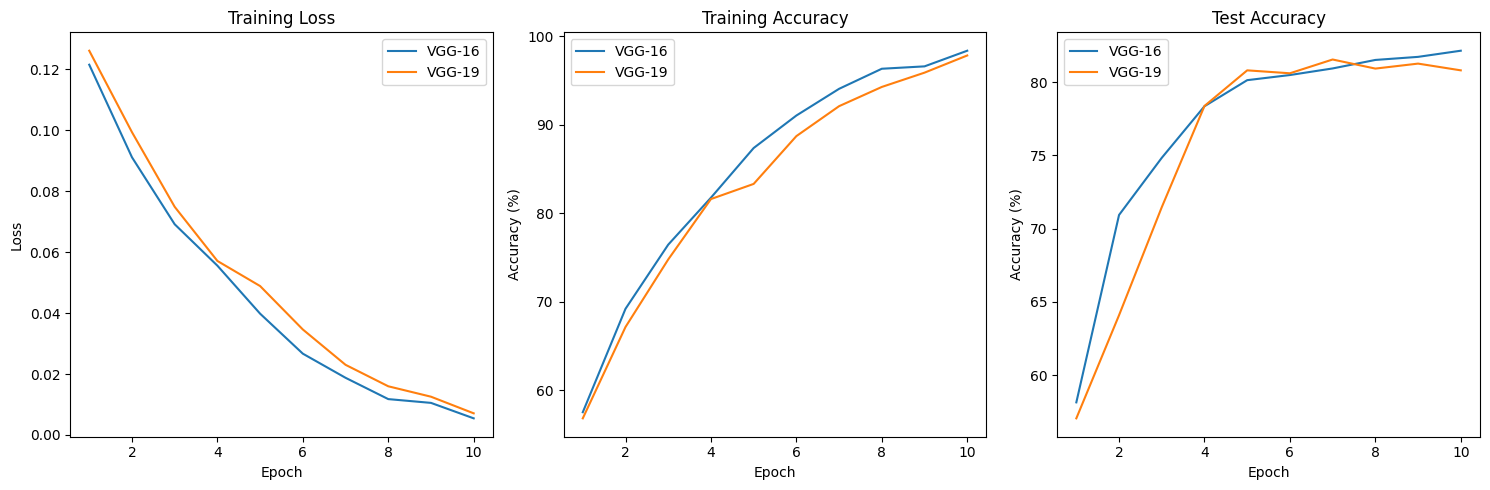


VGG-16 Summary:
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define VGG architecture
class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.cfg = {
            'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
            'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M']
        }
        self.features = self._make_layers(self.cfg[vgg_name])
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),  # Adjusted for 224x224 input after 5 max-pooling layers
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 10)  # CIFAR-10 has 10 classes
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [
                    nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                    nn.BatchNorm2d(x),
                    nn.ReLU(inplace=True)
                ]
                in_channels = x
        return nn.Sequential(*layers)

# Data preprocessing and loading
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # VGG expects 224x224 images
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

# Initialize models
vgg16 = VGG('VGG16').to(device)
vgg19 = VGG('VGG19').to(device)

# Loss function and optimizers
criterion = nn.CrossEntropyLoss()
optimizer_vgg16 = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
optimizer_vgg19 = optim.SGD(vgg19.parameters(), lr=0.001, momentum=0.9)

# Training function with metrics tracking
def train_model(model, optimizer, num_epochs=10):
    model.train()
    train_losses = []
    train_accuracies = []
    test_accuracies = []
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if i % 100 == 99:
                batch_loss = running_loss / 100
                batch_acc = 100 * correct / total
                print(f'[Epoch {epoch + 1}, Batch {i + 1}] Loss: {batch_loss:.3f}, Accuracy: {batch_acc:.2f}%')
                running_loss = 0.0
                correct = 0
                total = 0
        
        # Compute epoch metrics
        epoch_loss = running_loss / len(trainloader)
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        # Evaluate on test set
        test_acc = evaluate_model(model, verbose=False)
        test_accuracies.append(test_acc)
    
    return train_losses, train_accuracies, test_accuracies

# Evaluation function
def evaluate_model(model, verbose=True):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0.0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    if verbose:
        print(f'Test Loss: {test_loss / len(testloader):.3f}, Accuracy: {accuracy:.2f}%')
    return accuracy

# Train and evaluate VGG-16
print("Training VGG-16...")
vgg16_train_losses, vgg16_train_accs, vgg16_test_accs = train_model(vgg16, optimizer_vgg16, num_epochs=10)
print("\nEvaluating VGG-16...")
evaluate_model(vgg16)

# Train and evaluate VGG-19
print("\nTraining VGG-19...")
vgg19_train_losses, vgg19_train_accs, vgg19_test_accs = train_model(vgg19, optimizer_vgg19, num_epochs=10)
print("\nEvaluating VGG-19...")
evaluate_model(vgg19)

# Save models
torch.save(vgg16.state_dict(), 'vgg16_cifar10.pth')
torch.save(vgg19.state_dict(), 'vgg19_cifar10.pth')

# Plotting results
plt.figure(figsize=(15, 5))

# Plot Training Loss
plt.subplot(1, 3, 1)
plt.plot(range(1, 11), vgg16_train_losses, label='VGG-16')
plt.plot(range(1, 11), vgg19_train_losses, label='VGG-19')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Training Accuracy
plt.subplot(1, 3, 2)
plt.plot(range(1, 11), vgg16_train_accs, label='VGG-16')
plt.plot(range(1, 11), vgg19_train_accs, label='VGG-19')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

# Plot Test Accuracy
plt.subplot(1, 3, 3)
plt.plot(range(1, 11), vgg16_test_accs, label='VGG-16')
plt.plot(range(1, 11), vgg19_test_accs, label='VGG-19')
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

# Print model summaries
print("\nVGG-16 Summary:")
print(vgg16)
print("\nVGG-19 Summary:")
print(vgg19)